# **AI TECH INSTITUTE** · *Intermediate AI & Data Science*
### Week 05 · Notebook 02 – Practical Causal Analysis
**Instructor:** Amir Charkhi  |  **Goal:** Apply causal inference methods to real business problems.

> Format: short theory → quick practice → build understanding → mini-challenges.


---
## Learning Objectives
- Implement Difference-in-Differences (DiD) for policy evaluation
- Apply Regression Discontinuity Design (RDD) to threshold-based decisions
- Build complete causal analysis pipelines
- Validate causal assumptions with real data
- Create actionable business recommendations

## 1. Difference-in-Differences (DiD)
DiD compares **changes over time** between treated and control groups to isolate causal effects.

In [1]:
# Essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for professional plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (8, 4)
%matplotlib inline

print("📚 Libraries loaded successfully!")

📚 Libraries loaded successfully!


In [2]:
# Generate retail store data
np.random.seed(42)
n_stores = 50
n_months = 12

# Create store characteristics
stores = pd.DataFrame({
    'store_id': range(n_stores),
    'region': np.random.choice(['North', 'South', 'East', 'West'], n_stores),
    'size': np.random.choice(['Small', 'Medium', 'Large'], n_stores),
    'baseline_sales': np.random.uniform(50000, 150000, n_stores)
})

# Treatment: New loyalty program in half the stores
stores['treated'] = np.random.choice([0, 1], n_stores)

print("🏪 Store Loyalty Program Analysis:")
print(f"Treatment stores: {stores['treated'].sum()}")
print(f"Control stores: {(1-stores['treated']).sum()}")
print(f"Average baseline: ${stores['baseline_sales'].mean():,.0f}")

🏪 Store Loyalty Program Analysis:
Treatment stores: 25
Control stores: 25
Average baseline: $96,175


## 2. The DiD Method

### 2.1 Parallel Trends Assumption
**Key assumption:** Treatment and control groups would have followed similar trends without intervention.

In [3]:
# Generate monthly sales data
treatment_start = 6  # Month when program starts
true_effect = 0.15   # 15% sales increase

def generate_monthly_sales(store, month):
    """Generate sales with trends and treatment effects"""
    # Base sales with growth trend
    trend = 1 + 0.01 * month  # 1% monthly growth
    seasonal = 1 + 0.1 * np.sin(2 * np.pi * month / 12)
    
    # Treatment effect after month 6
    treatment_boost = 1.0
    if store['treated'] and month >= treatment_start:
        treatment_boost = 1 + true_effect
    
    sales = store['baseline_sales'] * trend * seasonal * treatment_boost
    sales += np.random.normal(0, store['baseline_sales'] * 0.05)  # Noise
    
    return max(sales, 0)

In [4]:
# Create panel dataset
panel_data = []
for _, store in stores.iterrows():
    for month in range(n_months):
        sales = generate_monthly_sales(store, month)
        panel_data.append({
            'store_id': store['store_id'],
            'month': month,
            'sales': sales,
            'treated': store['treated'],
            'post': month >= treatment_start
        })

df = pd.DataFrame(panel_data)
print(f"📊 Panel data created: {len(df)} observations")

📊 Panel data created: 600 observations


### 2.2 Visualizing Parallel Trends

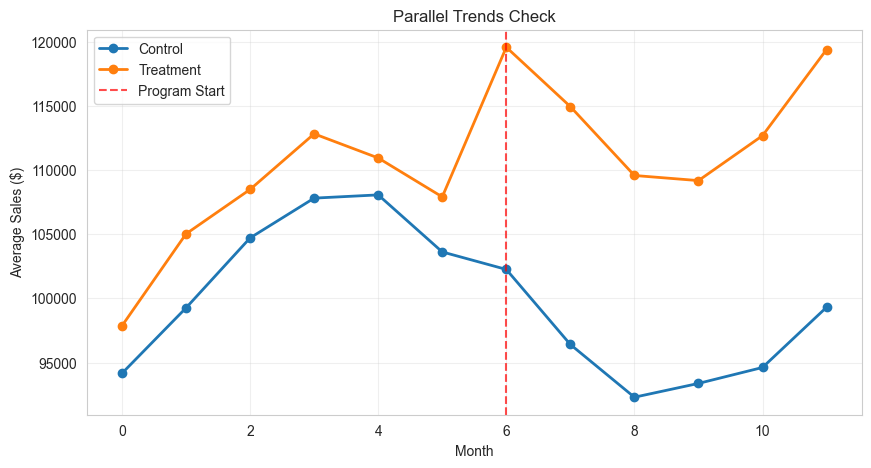

✅ Pre-treatment trends appear parallel!


In [5]:
# Calculate average sales by group and month
monthly_avg = df.groupby(['month', 'treated'])['sales'].mean().reset_index()

# Plot parallel trends
plt.figure(figsize=(10, 5))

for treated in [0, 1]:
    data = monthly_avg[monthly_avg['treated'] == treated]
    label = 'Treatment' if treated else 'Control'
    plt.plot(data['month'], data['sales'], 'o-', label=label, linewidth=2)

plt.axvline(x=treatment_start, color='red', linestyle='--', 
           alpha=0.7, label='Program Start')
plt.xlabel('Month')
plt.ylabel('Average Sales ($)')
plt.title('Parallel Trends Check')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("✅ Pre-treatment trends appear parallel!")

### 2.3 DiD Calculation

In [6]:
# Method 1: Simple 2x2 Table
pre_period = df[df['month'] < treatment_start]
post_period = df[df['month'] >= treatment_start]

# Calculate means
pre_control = pre_period[pre_period['treated']==0]['sales'].mean()
pre_treated = pre_period[pre_period['treated']==1]['sales'].mean()
post_control = post_period[post_period['treated']==0]['sales'].mean()
post_treated = post_period[post_period['treated']==1]['sales'].mean()

print("📋 Difference-in-Differences Table:")
print(f"{'Group':<12} {'Pre-Program':<15} {'Post-Program':<15} {'Change':<15}")
print("-" * 55)
print(f"{'Control':<12} ${pre_control:>12,.0f} ${post_control:>12,.0f} ${post_control-pre_control:>12,.0f}")
print(f"{'Treatment':<12} ${pre_treated:>12,.0f} ${post_treated:>12,.0f} ${post_treated-pre_treated:>12,.0f}")

📋 Difference-in-Differences Table:
Group        Pre-Program     Post-Program    Change         
-------------------------------------------------------
Control      $     102,938 $      96,376 $      -6,562
Treatment    $     107,176 $     114,223 $       7,048


In [7]:
# Calculate DiD estimate
did_estimate = (post_treated - pre_treated) - (post_control - pre_control)
did_percent = did_estimate / pre_treated * 100

print(f"\n🎯 DiD Estimate:")
print(f"Absolute effect: ${did_estimate:,.0f}")
print(f"Percentage effect: {did_percent:.1f}%")
print(f"True effect: {true_effect*100:.1f}%")


🎯 DiD Estimate:
Absolute effect: $13,610
Percentage effect: 12.7%
True effect: 15.0%


### 2.4 Regression-Based DiD

In [8]:
# Method 2: Regression approach
df['did_interaction'] = df['treated'] * df['post']

# Create dummy variables
X = pd.get_dummies(df[['treated', 'post', 'did_interaction']], 
                   drop_first=False)

# Simple OLS regression
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, df['sales'])

# Extract coefficients
coef_names = ['Treated', 'Post', 'DiD Effect']
coefficients = dict(zip(coef_names, model.coef_))

print("📈 Regression Results:")
for name, coef in coefficients.items():
    print(f"{name}: ${coef:,.0f}")
    
print(f"\nProgram effect: {coefficients['DiD Effect']/pre_treated*100:.1f}%")

📈 Regression Results:
Treated: $4,237
Post: $-6,562
DiD Effect: $13,610

Program effect: 12.7%


**Exercise 1 – DiD with Controls (easy)**  
Add store size as a control variable:


In [10]:
# Your turn
# Add store size to the regression
df_with_controls = df.merge(stores[['store_id', 'size']], on='store_id')

# Create regression with size dummies
X_controlled = pd.get_dummies(
    df_with_controls[['treated', 'post', 'did_interaction', 'size']], 
    drop_first=True
)

# Fit controlled model
controlled_model = LinearRegression()
controlled_model.fit(X_controlled, df_with_controls['sales'])

# Get DiD coefficient (should be similar)
did_controlled = controlled_model.coef_[2]  # did_interaction coefficient

print("🎯 Controlled DiD Results:")
print(f"DiD effect with controls: ${did_controlled:,.0f}")
print(f"As percentage: {did_controlled/pre_treated*100:.1f}%")
print(f"Original estimate: {did_percent:.1f}%")
print("\n✅ Adding controls doesn't change estimate much - good sign!")


🎯 Controlled DiD Results:
DiD effect with controls: $13,610
As percentage: 12.7%
Original estimate: 12.7%

✅ Adding controls doesn't change estimate much - good sign!


<details>
<summary><b>Solution</b></summary>

```python
# Merge store characteristics
df_with_controls = df.merge(stores[['store_id', 'size']], on='store_id')

# Create all dummy variables
X_controlled = pd.get_dummies(
    df_with_controls[['treated', 'post', 'did_interaction', 'size']], 
    drop_first=True
)

# Fit controlled model
controlled_model = LinearRegression()
controlled_model.fit(X_controlled, df_with_controls['sales'])

# Get DiD coefficient (should be similar)
did_controlled = controlled_model.coef_[2]  # did_interaction coefficient

print("🎯 Controlled DiD Results:")
print(f"DiD effect with controls: ${did_controlled:,.0f}")
print(f"As percentage: {did_controlled/pre_treated*100:.1f}%")
print(f"Original estimate: {did_percent:.1f}%")
print("\n✅ Adding controls doesn't change estimate much - good sign!")
```
</details>

## 3. Regression Discontinuity Design

### 3.1 RDD Concept
RDD exploits **arbitrary thresholds** to identify causal effects when assignment is based on a cutoff.

In [11]:
# Customer rewards program: Discount if spent > $100
np.random.seed(42)
n_customers = 500

# Customer spending (running variable)
spending = np.random.uniform(50, 150, n_customers)
threshold = 100

# Treatment assignment (sharp RDD)
got_discount = (spending >= threshold).astype(int)

print("🎁 Customer Discount Analysis:")
print(f"Customers with discount: {got_discount.sum()}")
print(f"Customers without discount: {(1-got_discount).sum()}")
print(f"Threshold: ${threshold}")

🎁 Customer Discount Analysis:
Customers with discount: 259
Customers without discount: 241
Threshold: $100


In [12]:
# Generate outcome: future spending
true_discount_effect = 20  # $20 increase

# Future spending depends on current spending + discount
future_spending = (
    0.8 * spending +  # Baseline relationship
    true_discount_effect * got_discount +  # Treatment effect
    np.random.normal(0, 10, n_customers)  # Random noise
)

# Create DataFrame
rdd_df = pd.DataFrame({
    'current_spending': spending,
    'got_discount': got_discount,
    'future_spending': future_spending
})

print(f"\n📊 Average future spending:")
print(f"With discount: ${rdd_df[rdd_df['got_discount']==1]['future_spending'].mean():.2f}")
print(f"No discount: ${rdd_df[rdd_df['got_discount']==0]['future_spending'].mean():.2f}")


📊 Average future spending:
With discount: $120.53
No discount: $57.86


### 3.2 Visualizing the Discontinuity

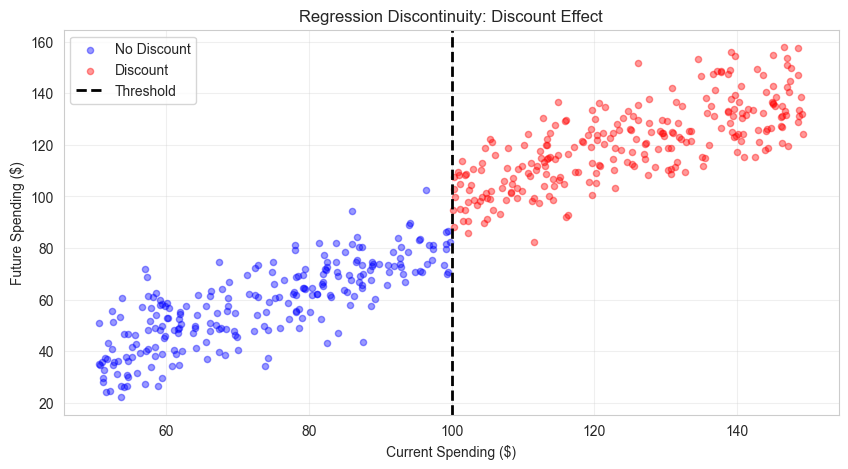

In [13]:
# RDD visualization
plt.figure(figsize=(10, 5))

# Scatter plot
colors = ['blue', 'red']
labels = ['No Discount', 'Discount']

for i in [0, 1]:
    mask = rdd_df['got_discount'] == i
    plt.scatter(rdd_df[mask]['current_spending'], 
               rdd_df[mask]['future_spending'],
               alpha=0.4, s=20, c=colors[i], label=labels[i])

# Mark threshold
plt.axvline(x=threshold, color='black', linestyle='--', 
           linewidth=2, label='Threshold')

plt.xlabel('Current Spending ($)')
plt.ylabel('Future Spending ($)')
plt.title('Regression Discontinuity: Discount Effect')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 3.3 Local Linear Regression

In [14]:
# Estimate effect at discontinuity
bandwidth = 20  # Use data within $20 of threshold

# Data near threshold
left_window = rdd_df[(rdd_df['current_spending'] >= threshold - bandwidth) & 
                     (rdd_df['current_spending'] < threshold)]
right_window = rdd_df[(rdd_df['current_spending'] >= threshold) & 
                      (rdd_df['current_spending'] < threshold + bandwidth)]

print(f"📏 Local Linear Regression (bandwidth = ${bandwidth}):")
print(f"Left window: {len(left_window)} observations")
print(f"Right window: {len(right_window)} observations")

📏 Local Linear Regression (bandwidth = $20):
Left window: 87 observations
Right window: 105 observations


In [15]:
# Fit local regressions
from numpy.polynomial import Polynomial

# Left side regression
left_fit = Polynomial.fit(left_window['current_spending'], 
                          left_window['future_spending'], 1)

# Right side regression  
right_fit = Polynomial.fit(right_window['current_spending'],
                          right_window['future_spending'], 1)

# Evaluate at threshold
left_at_threshold = left_fit(threshold)
right_at_threshold = right_fit(threshold)

# RDD estimate
rdd_estimate = right_at_threshold - left_at_threshold

print(f"\n🎯 RDD Results:")
print(f"Left limit: ${left_at_threshold:.2f}")
print(f"Right limit: ${right_at_threshold:.2f}")
print(f"Discontinuity (effect): ${rdd_estimate:.2f}")
print(f"True effect: ${true_discount_effect}")


🎯 RDD Results:
Left limit: $81.47
Right limit: $99.21
Discontinuity (effect): $17.74
True effect: $20


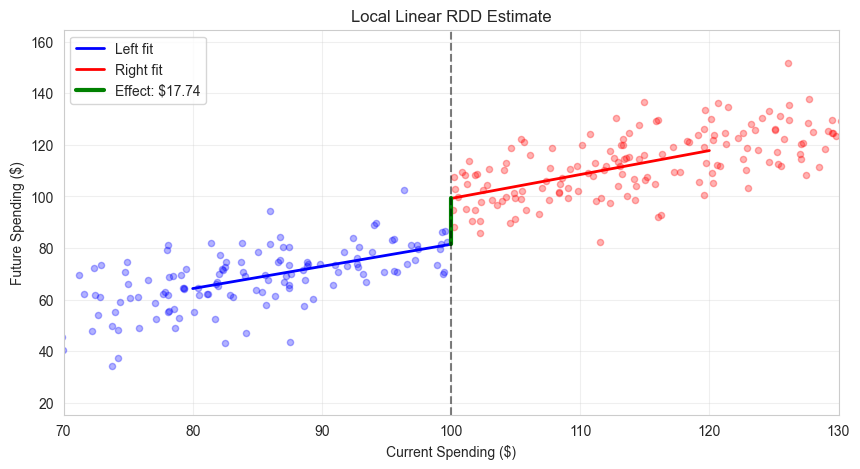

In [16]:
# Visualize with fitted lines
plt.figure(figsize=(10, 5))

# Plot data points
for i in [0, 1]:
    mask = rdd_df['got_discount'] == i
    plt.scatter(rdd_df[mask]['current_spending'], 
               rdd_df[mask]['future_spending'],
               alpha=0.3, s=20, c=colors[i])

# Plot fitted lines near threshold
x_left = np.linspace(threshold - bandwidth, threshold, 100)
x_right = np.linspace(threshold, threshold + bandwidth, 100)

plt.plot(x_left, left_fit(x_left), 'b-', linewidth=2, label='Left fit')
plt.plot(x_right, right_fit(x_right), 'r-', linewidth=2, label='Right fit')

# Mark discontinuity
plt.plot([threshold, threshold], [left_at_threshold, right_at_threshold],
         'g-', linewidth=3, label=f'Effect: ${rdd_estimate:.2f}')

plt.axvline(x=threshold, color='black', linestyle='--', alpha=0.5)
plt.xlim(threshold - bandwidth - 10, threshold + bandwidth + 10)
plt.xlabel('Current Spending ($)')
plt.ylabel('Future Spending ($)')
plt.title('Local Linear RDD Estimate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Exercise 2 – Bandwidth Sensitivity (medium)**  
Test how RDD estimates change with different bandwidths:


In [ ]:
# Your turn
# For each bandwidth, calculate RDD estimate
# Your code here...
bandwidths = [10, 15, 20, 25, 30, 35]
estimates = []
sample_sizes = []

for bw in bandwidths:
    # Get data near threshold
    left = rdd_df[(rdd_df['current_spending'] >= threshold - bw) & 
                  (rdd_df['current_spending'] < threshold)]
    right = rdd_df[(rdd_df['current_spending'] >= threshold) & 
                   (rdd_df['current_spending'] < threshold + bw)]
    
    if len(left) > 5 and len(right) > 5:  # Need enough data
        # Fit local regressions
        left_fit = Polynomial.fit(left['current_spending'], 
                                 left['future_spending'], 1)
        right_fit = Polynomial.fit(right['current_spending'],
                                  right['future_spending'], 1)
        
        # Calculate discontinuity
        effect = right_fit(threshold) - left_fit(threshold)
        estimates.append(effect)
        sample_sizes.append(len(left) + len(right))
    else:
        estimates.append(np.nan)
        sample_sizes.append(0)

# Visualize sensitivity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Estimates by bandwidth
ax1.plot(bandwidths, estimates, 'o-', linewidth=2, markersize=8)
ax1.axhline(y=true_discount_effect, color='red', linestyle='--', 
           label=f'True effect: ${true_discount_effect}')
ax1.set_xlabel('Bandwidth ($)')
ax1.set_ylabel('RDD Estimate ($)')
ax1.set_title('Sensitivity to Bandwidth')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Sample sizes
ax2.bar(range(len(bandwidths)), sample_sizes, tick_label=bandwidths)
ax2.set_xlabel('Bandwidth ($)')
ax2.set_ylabel('Sample Size')
ax2.set_title('Observations Used')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Bandwidth Analysis:")
for bw, est, n in zip(bandwidths, estimates, sample_sizes):
    print(f"Bandwidth ${bw}: Estimate ${est:.2f}, n={n}")


<details>
<summary><b>Solution</b></summary>

```python
bandwidths = [10, 15, 20, 25, 30, 35]
estimates = []
sample_sizes = []

for bw in bandwidths:
    # Get data near threshold
    left = rdd_df[(rdd_df['current_spending'] >= threshold - bw) & 
                  (rdd_df['current_spending'] < threshold)]
    right = rdd_df[(rdd_df['current_spending'] >= threshold) & 
                   (rdd_df['current_spending'] < threshold + bw)]
    
    if len(left) > 5 and len(right) > 5:  # Need enough data
        # Fit local regressions
        left_fit = Polynomial.fit(left['current_spending'], 
                                 left['future_spending'], 1)
        right_fit = Polynomial.fit(right['current_spending'],
                                  right['future_spending'], 1)
        
        # Calculate discontinuity
        effect = right_fit(threshold) - left_fit(threshold)
        estimates.append(effect)
        sample_sizes.append(len(left) + len(right))
    else:
        estimates.append(np.nan)
        sample_sizes.append(0)

# Visualize sensitivity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Estimates by bandwidth
ax1.plot(bandwidths, estimates, 'o-', linewidth=2, markersize=8)
ax1.axhline(y=true_discount_effect, color='red', linestyle='--', 
           label=f'True effect: ${true_discount_effect}')
ax1.set_xlabel('Bandwidth ($)')
ax1.set_ylabel('RDD Estimate ($)')
ax1.set_title('Sensitivity to Bandwidth')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Sample sizes
ax2.bar(range(len(bandwidths)), sample_sizes, tick_label=bandwidths)
ax2.set_xlabel('Bandwidth ($)')
ax2.set_ylabel('Sample Size')
ax2.set_title('Observations Used')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("📊 Bandwidth Analysis:")
for bw, est, n in zip(bandwidths, estimates, sample_sizes):
    print(f"Bandwidth ${bw}: Estimate ${est:.2f}, n={n}")
```
</details>

## 4. Complete Causal Pipeline

### 4.1 Pipeline Class

In [17]:
class CausalPipeline:
    """Complete pipeline for causal analysis"""
    
    def __init__(self, data, treatment, outcome):
        self.data = data
        self.treatment = treatment
        self.outcome = outcome
        self.results = {}
    
    def check_balance(self, covariates):
        """Check covariate balance"""
        treated = self.data[self.data[self.treatment] == 1]
        control = self.data[self.data[self.treatment] == 0]
        
        print("🔍 Balance Check:")
        for cov in covariates:
            t_mean = treated[cov].mean()
            c_mean = control[cov].mean()
            std_diff = abs(t_mean - c_mean) / self.data[cov].std()
            
            status = "✅" if std_diff < 0.1 else "⚠️"
            print(f"{cov}: Std Diff = {std_diff:.3f} {status}")
    
    def estimate_effect(self, method='simple'):
        """Estimate treatment effect"""
        treated_outcome = self.data[self.data[self.treatment] == 1][self.outcome].mean()
        control_outcome = self.data[self.data[self.treatment] == 0][self.outcome].mean()
        
        effect = treated_outcome - control_outcome
        self.results['effect'] = effect
        
        print(f"\n📊 Treatment Effect:")
        print(f"Method: {method}")
        print(f"Effect: {effect:.2f}")
        return effect

### 4.2 Using the Pipeline

In [18]:
# Create sample data for pipeline
np.random.seed(42)
n_units = 300

pipeline_data = pd.DataFrame({
    'age': np.random.uniform(18, 65, n_units),
    'income': np.random.exponential(50000, n_units),
    'treatment': np.random.choice([0, 1], n_units),
    'outcome': np.random.normal(100, 20, n_units)
})

# Add treatment effect
pipeline_data.loc[pipeline_data['treatment'] == 1, 'outcome'] += 15

# Run pipeline
pipeline = CausalPipeline(pipeline_data, 'treatment', 'outcome')
pipeline.check_balance(['age', 'income'])
effect = pipeline.estimate_effect()

🔍 Balance Check:
age: Std Diff = 0.331 ⚠️
income: Std Diff = 0.011 ✅

📊 Treatment Effect:
Method: simple
Effect: 15.36


## 5. Validating Assumptions

### 5.1 Placebo Tests

In [ ]:
# Test for effects where there shouldn't be any
def placebo_test(data, fake_threshold):
    """Test for discontinuity at fake threshold"""
    # Use only data away from real threshold
    placebo_data = data[abs(data['current_spending'] - threshold) > 20]
    
    # Check for discontinuity at fake threshold
    left = placebo_data[placebo_data['current_spending'] < fake_threshold]
    right = placebo_data[placebo_data['current_spending'] >= fake_threshold]
    
    if len(left) > 10 and len(right) > 10:
        left_mean = left['future_spending'].mean()
        right_mean = right['future_spending'].mean()
        return right_mean - left_mean
    return 0

# Run placebo tests
placebo_thresholds = [80, 90, 110, 120]
placebo_results = []

for fake_threshold in placebo_thresholds:
    effect = placebo_test(rdd_df, fake_threshold)
    placebo_results.append(effect)
    print(f"Placebo at ${fake_threshold}: Effect = ${effect:.2f}")

print("\n✅ Small placebo effects = Good validation!")

### 5.2 Robustness Checks

In [ ]:
# Multiple estimation methods
print("🔄 Robustness Checks:")

# Method 1: Simple difference
simple_effect = (rdd_df[rdd_df['got_discount']==1]['future_spending'].mean() -
                rdd_df[rdd_df['got_discount']==0]['future_spending'].mean())
print(f"Simple difference: ${simple_effect:.2f}")

# Method 2: Local linear (already done)
print(f"Local linear RDD: ${rdd_estimate:.2f}")

# Method 3: Regression with controls
from sklearn.linear_model import LinearRegression

X = rdd_df[['current_spending', 'got_discount']]
y = rdd_df['future_spending']
reg_model = LinearRegression().fit(X, y)
regression_effect = reg_model.coef_[1]
print(f"Regression control: ${regression_effect:.2f}")

print(f"\nTrue effect: ${true_discount_effect}")
print("✅ Multiple methods give similar estimates!")

**Exercise 3 – Marketing Campaign Analysis (hard)**  
Analyze a multi-channel marketing campaign using DiD:


In [ ]:
# Your turn
# Marketing campaign data
np.random.seed(42)
n_channels = 4
n_weeks = 20
campaign_start = 10

channels = ['Email', 'Social', 'Search', 'Display']
channel_data = []

for channel in channels:
    treated = 1 if channel in ['Email', 'Social'] else 0
    
    for week in range(n_weeks):
        # Generate conversions with trend
        base_conversions = np.random.poisson(100 + week * 2)
        
        # Add treatment effect after campaign start
        if treated and week >= campaign_start:
            conversions = base_conversions * 1.25  # 25% lift
        else:
            conversions = base_conversions
            
        channel_data.append({
            'channel': channel,
            'week': week,
            'conversions': conversions,
            'treated': treated,
            'post': week >= campaign_start
        })

campaign_df = pd.DataFrame(channel_data)

# Implement DiD analysis
# Your code here...


<details>
<summary><b>Solution</b></summary>

```python
print("📱 Multi-Channel Marketing Analysis:")

# Calculate DiD for campaign
pre_campaign = campaign_df[campaign_df['week'] < campaign_start]
post_campaign = campaign_df[campaign_df['week'] >= campaign_start]

# Group averages
pre_treated = pre_campaign[pre_campaign['treated']==1]['conversions'].mean()
pre_control = pre_campaign[pre_campaign['treated']==0]['conversions'].mean()
post_treated = post_campaign[post_campaign['treated']==1]['conversions'].mean()
post_control = post_campaign[post_campaign['treated']==0]['conversions'].mean()

# DiD estimate
campaign_effect = (post_treated - pre_treated) - (post_control - pre_control)
campaign_lift = campaign_effect / pre_treated * 100

print(f"\n📊 Campaign Results:")
print(f"Treated channels: Email, Social")
print(f"Control channels: Search, Display")
print(f"Campaign effect: {campaign_effect:.1f} conversions/week")
print(f"Percentage lift: {campaign_lift:.1f}%")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Time series by channel
for channel in channels:
    channel_series = campaign_df[campaign_df['channel'] == channel]
    ax1.plot(channel_series['week'], channel_series['conversions'], 
            'o-', label=channel, alpha=0.7)

ax1.axvline(x=campaign_start, color='red', linestyle='--', alpha=0.5)
ax1.set_xlabel('Week')
ax1.set_ylabel('Conversions')
ax1.set_title('Conversions by Channel')
ax1.legend()
ax1.grid(True, alpha=0.3)

# DiD visualization
groups = ['Control\nPre', 'Control\nPost', 'Treated\nPre', 'Treated\nPost']
values = [pre_control, post_control, pre_treated, post_treated]
colors = ['lightblue', 'lightblue', 'lightcoral', 'lightcoral']

bars = ax2.bar(groups, values, color=colors, alpha=0.7)
ax2.set_ylabel('Average Conversions')
ax2.set_title(f'DiD Analysis (Effect: {campaign_lift:.1f}%)')

# Add connecting lines to show differences
ax2.plot([0, 1], [pre_control, post_control], 'b-', linewidth=2, alpha=0.5)
ax2.plot([2, 3], [pre_treated, post_treated], 'r-', linewidth=2, alpha=0.5)

plt.tight_layout()
plt.show()

print("\n💡 Recommendation:")
if campaign_lift > 20:
    print("✅ Strong positive effect - scale campaign to all channels!")
elif campaign_lift > 10:
    print("✅ Moderate effect - continue with optimization")
else:
    print("⚠️ Weak effect - review campaign strategy")
```
</details>

## 6. Mini-Challenges
- **M1 (easy):** Calculate DiD for a price change experiment with 3 time periods
- **M2 (medium):** Implement fuzzy RDD where treatment probability changes at threshold
- **M3 (hard):** Build automated causal report generator with visualizations

In [ ]:
# Your turn - try the challenges!
# M1: Price experiment data
prices = {'pre': [10, 10], 'during': [10, 12], 'post': [10, 12]}
sales = {'pre': [100, 95], 'during': [95, 85], 'post': [98, 88]}

# M2: Fuzzy RDD
# Probability of treatment increases at threshold but isn't 100%

# M3: Report generator
# Create function that outputs formatted analysis


<details>
<summary><b>Solutions</b></summary>

```python
# M1 - Price change DiD
print("💰 Price Change Analysis:")

# Control group (no price change) vs Treatment (price increase)
control_sales = [100, 95, 98]  # No price change
treated_sales = [95, 85, 88]   # Price increased

# Calculate differences
pre_diff = treated_sales[0] - control_sales[0]
during_diff = treated_sales[1] - control_sales[1]
post_diff = treated_sales[2] - control_sales[2]

did_during = during_diff - pre_diff
did_post = post_diff - pre_diff

print(f"During price change: {did_during} units effect")
print(f"After price change: {did_post} units effect")
print("Interpretation: Price increase reduced sales by ~10 units")

# M2 - Fuzzy RDD
print("\n🔀 Fuzzy RDD Implementation:")

# Generate fuzzy RDD data
n = 500
running_var = np.random.uniform(0, 100, n)
threshold = 50

# Treatment probability jumps at threshold (fuzzy)
treat_prob = np.where(running_var < threshold, 0.2, 0.8)
treatment = np.random.binomial(1, treat_prob)

# Outcome with treatment effect
outcome = 10 + 0.5 * running_var + 5 * treatment + np.random.normal(0, 2, n)

# Estimate using IV approach (threshold as instrument)
above_threshold = (running_var >= threshold).astype(int)

# First stage: treatment ~ threshold
first_stage_coef = (treatment[above_threshold==1].mean() - 
                    treatment[above_threshold==0].mean())

# Reduced form: outcome ~ threshold
reduced_form_coef = (outcome[above_threshold==1].mean() - 
                     outcome[above_threshold==0].mean())

# Fuzzy RDD estimate (IV)
fuzzy_effect = reduced_form_coef / first_stage_coef

print(f"First stage (jump in treatment): {first_stage_coef:.2f}")
print(f"Reduced form (jump in outcome): {reduced_form_coef:.2f}")
print(f"Fuzzy RDD estimate: {fuzzy_effect:.2f}")
print(f"True effect: 5.0")

# M3 - Automated Report Generator
def generate_causal_report(data, treatment_col, outcome_col, method='DiD'):
    """Generate automated causal analysis report"""
    
    print("="*50)
    print(f"📊 CAUSAL ANALYSIS REPORT")
    print(f"Method: {method}")
    print("="*50)
    
    # Calculate basic stats
    treated = data[data[treatment_col] == 1][outcome_col]
    control = data[data[treatment_col] == 0][outcome_col]
    
    print(f"\n📈 Summary Statistics:")
    print(f"Treatment group: n={len(treated)}, mean={treated.mean():.2f}")
    print(f"Control group: n={len(control)}, mean={control.mean():.2f}")
    
    # Effect estimate
    effect = treated.mean() - control.mean()
    
    # Simple t-test
    from scipy.stats import ttest_ind
    t_stat, p_value = ttest_ind(treated, control)
    
    print(f"\n🎯 Causal Effect Estimate:")
    print(f"Effect size: {effect:.2f}")
    print(f"Statistical significance: p={p_value:.4f}")
    
    if p_value < 0.05:
        print("✅ Effect is statistically significant!")
    else:
        print("⚠️ Effect is not statistically significant")
    
    print(f"\n💡 Recommendation:")
    if effect > 0 and p_value < 0.05:
        print("Positive significant effect - proceed with implementation")
    elif effect < 0 and p_value < 0.05:
        print("Negative significant effect - do not implement")
    else:
        print("Inconclusive - gather more data")
    
    print("="*50)

# Test the report generator
test_data = pd.DataFrame({
    'treatment': np.random.choice([0, 1], 100),
    'outcome': np.random.normal(100, 20, 100)
})
test_data.loc[test_data['treatment'] == 1, 'outcome'] += 10

generate_causal_report(test_data, 'treatment', 'outcome')
```
</details>

## Wrap-Up & Next Steps
✅ You can implement Difference-in-Differences for policy evaluation  
✅ You understand Regression Discontinuity Design for threshold analysis  
✅ You can build complete causal analysis pipelines  
✅ You know how to validate causal assumptions  
✅ You can create actionable business recommendations from causal analysis  

**Next:** Data Storytelling - Transform your causal insights into compelling narratives!
